# Imports

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import string
import os
import re
from numpy import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector
from datetime import datetime as dt
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
from tensorflow.keras.losses import BinaryCrossentropy
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-10 07:07:56--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-10 07:07:56 (77.2 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [ ]:
from helper_functions import (make_confusion_matrix, plot_loss_curves, calculate_results, plot_class_accuracy,
                              plot_prediction_confidence_histogram, create_tensorboard_callback)

# Data Downloading

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle competitions download -c fake-news
! unzip "/content/fake-news.zip" -d "/content/dataset/"

 86% 40.0M/46.5M [00:00<00:00, 121MB/s] 
100% 46.5M/46.5M [00:00<00:00, 110MB/s]
Archive:  /content/fake-news.zip
  inflating: /content/dataset/submit.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/train.csv  


# Data Loading

In [ ]:
df = pd.read_csv("/content/dataset/train.csv")

In [ ]:
df = df[['title', 'label']]

In [ ]:
df.head(5)

,title,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


In [ ]:
df.isnull().sum()

title    558
label      0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.duplicated().sum()

439

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19803 entries, 0 to 20798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   19803 non-null  object
 1   label   19803 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 464.1+ KB


In [ ]:
df['label'].value_counts()

0    10381
1     9422
Name: label, dtype: int64

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # Remove URL from string
    text = re.sub('<.*?>+', ' ', text) # Remove HTML Tags
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # Replace Punctuation with space
    text = re.sub('\n', ' ', text) # Replace NewLine with space
    text = re.sub(r'\w*\d\w*', ' ', text) # Remove alphanumeric
    text = text.replace('-', ' ')
    text = text.replace('’’', '').replace('’', '').replace('‘‘', '').replace('‘', '')
    text = ' '.join(text.split())  # Strip extra spaces
    return text

In [ ]:
clean_text("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this ** ?????? ?movie! would you?<br> <br /><br />T")

'in the movie man called tévèz went to a friends pl ce and they had a tensed discussion i dont love this movie would you t'

# BaseLine Machine Learning model

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.20)

In [ ]:
train_sentences = X_train.apply(clean_text)
test_sentences = X_test.apply(clean_text)
train_sentences = train_sentences.tolist()
test_sentences = test_sentences.tolist()

In [ ]:
class_labels = ['reliable', 'unreliable']
print("Labels in dataset are:", class_labels)

Labels in dataset are: ['reliable', 'unreliable']


In [ ]:
print("Training Examples:")
len(train_sentences), len(y_train)

Training Examples:


(15842, 15842)

In [ ]:
print("Test Examples:")
len(test_sentences), len(y_test)

Test Examples:


(3961, 3961)

# Baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

baseline_model = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

baseline_model.fit(X = train_sentences,
                   y = y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_model.score(X = test_sentences,
                     y = y_test)

0.8621560212067659

In [ ]:
baseline_preds = baseline_model.predict(test_sentences)

In [ ]:
baseline_results = calculate_results(y_true = y_test,
                                     y_pred = baseline_preds)

In [ ]:
baseline_results

{'accuracy': 86.21560212067659,
 'precision': 0.8739195141354215,
 'recall': 0.8621560212067659,
 'f1': 0.8605300412753835}

# Word Leval Tokenization and Embeddings

In [ ]:
sentences_length = [len(sentence.split()) for sentence in df['title']]
avg_sentence_length = np.mean(sentences_length)
print(avg_sentence_length)

12.469979296066253


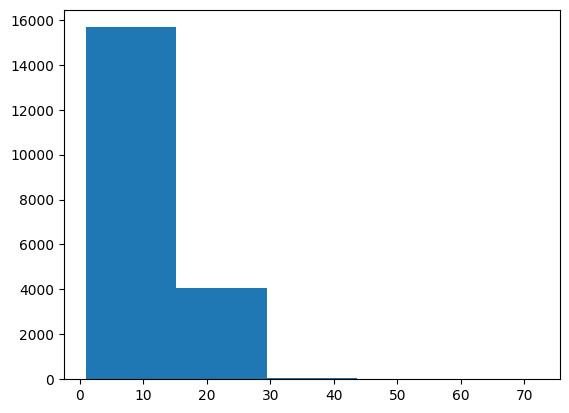

In [ ]:
plt.hist(sentences_length, bins=5);

In [ ]:
output_sequence_length = int(np.percentile(sentences_length, 95))
print(output_sequence_length)

18


In [ ]:
max_tokens = 10000
vectorize_layer = TextVectorization(max_tokens = max_tokens,
                                    output_mode = 'int',
                                    standardize = None,
                                    output_sequence_length = 18)

vectorize_layer.adapt(train_sentences)

In [ ]:
random_sentence = random.choice(train_sentences)
print('Sentence:', random_sentence)
print('Length of sentence:', len(random_sentence.split()))
print('Vectorized_Form:', vectorize_layer([random_sentence]))

Sentence: texas official sees record breaking turnout and its all for trump
Length of sentence: 11
Vectorized_Form: tf.Tensor(
[[ 180  537 1276  583  110 1792   13   53   81   12    9    0    0    0
     0    0    0    0]], shape=(1, 18), dtype=int64)


In [ ]:
text_vocab = vectorize_layer.get_vocabulary()
print("Total number of words in vocalbuary", len(text_vocab))
print("The Top Most 5 common words in vocalbuary:", text_vocab[:5])
print("The Least Most 5 common words in vocalbuary:", text_vocab[-5:])

Total number of words in vocalbuary 10000
The Top Most 5 common words in vocalbuary: ['', '[UNK]', 'the', 'new', 'york']
The Least Most 5 common words in vocalbuary: ['boxes', 'bourne', 'bottles', 'bottled', 'bossert']


In [ ]:
vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 10000,
 'standardize': None,
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 18,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 10000}

In [ ]:
token_embed = Embedding(input_dim = 10000,
                        output_dim = 128,
                        name = "Embeddings")

In [ ]:
target_sentence = random.choice(train_sentences)
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
california cops accuse illegal immigrant of child sex abuse

Sentence after vectorization (before embedding):
[[ 170  947 5640  155 1301    8  355  239 1038    0    0    0    0    0
     0    0    0    0]]

Sentence after embedding:
[[[ 0.01992005 -0.01138754  0.0212757  ...  0.016477   -0.02430466
   -0.01670487]
  [-0.00061655 -0.01680808 -0.02944727 ... -0.00059053 -0.03045539
   -0.02459041]
  [ 0.00316625 -0.03551261  0.01221048 ... -0.02682389  0.03027674
   -0.03686887]
  ...
  [-0.01414738  0.01926342 -0.03064513 ... -0.03870002 -0.00540376
   -0.04228274]
  [-0.01414738  0.01926342 -0.03064513 ... -0.03870002 -0.00540376
   -0.04228274]
  [-0.01414738  0.01926342 -0.03064513 ... -0.03870002 -0.00540376
   -0.04228274]]]

Embedded sentence shape: (1, 18, 128)


# Data Loading

In [ ]:
news_label = df['label'].value_counts().index
values = df['label'].value_counts().values
total_samples = 19803
weights = {}
for label, value in zip(news_label, values):
  weights[label] = total_samples / value

print("Weights:", weights)

Weights: {0: 1.9076196898179367, 1: 2.1017830609212482}


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, y_test))

In [ ]:
for sentences, labels in train_dataset.take(1):
  print("Sentence = ", sentences)
  print("Labels = ", labels)

Sentence =  tf.Tensor(b'maher were gassing syrians too with syrian problem started with climate change breitbart', shape=(), dtype=string)
Labels =  tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
train_dataset = train_dataset.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for sentences, labels in train_dataset.take(1):
  for i in range(5):
    print("Sentence = ", sentences[i])
    print("Labels = ", labels[i])

Sentence =  tf.Tensor(b'maher were gassing syrians too with syrian problem started with climate change breitbart', shape=(), dtype=string)
Labels =  tf.Tensor(0, shape=(), dtype=int64)
Sentence =  tf.Tensor(b'dropout by dartmouth raises questions on health law cost savings effort the new york times', shape=(), dtype=string)
Labels =  tf.Tensor(0, shape=(), dtype=int64)
Sentence =  tf.Tensor(b'barrel bomb the cataclysmic close of campaign information', shape=(), dtype=string)
Labels =  tf.Tensor(1, shape=(), dtype=int64)
Sentence =  tf.Tensor(b'jimmy breslin legendary new york city newspaper columnist dies at the new york times', shape=(), dtype=string)
Labels =  tf.Tensor(0, shape=(), dtype=int64)
Sentence =  tf.Tensor(b'woman thrown in front of train at times square subway station is killed the new york times', shape=(), dtype=string)
Labels =  tf.Tensor(0, shape=(), dtype=int64)


# Tensorboard Callback

In [ ]:
# Directory for tensorboard callback
os.mkdir("logs")

In [ ]:
def create_tensorboard_callback(model_name):
    log_dir = os.path.join("logs", model_name + "_" + dt.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    return tensorboard_callback

# Simple RNN Model

In [ ]:
input_layer = Input(shape=(1, ), dtype=tf.string)
text_vectors = vectorize_layer(input_layer)
token_embeddings = token_embed(text_vectors)
x = Bidirectional(SimpleRNN(units=64, return_sequences=True))(token_embeddings)
x = Bidirectional(SimpleRNN(units=32, return_sequences=True))(x)
x = Bidirectional(SimpleRNN(units=16))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_1 = Model(inputs = input_layer,
                outputs = output_layer)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 Embeddings (Embedding)      (None, 18, 128)           1024000   
                                                                 
 bidirectional (Bidirectiona  (None, 18, 128)          24704     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 18, 64)           10304     
 nal)                                                            
                                                             

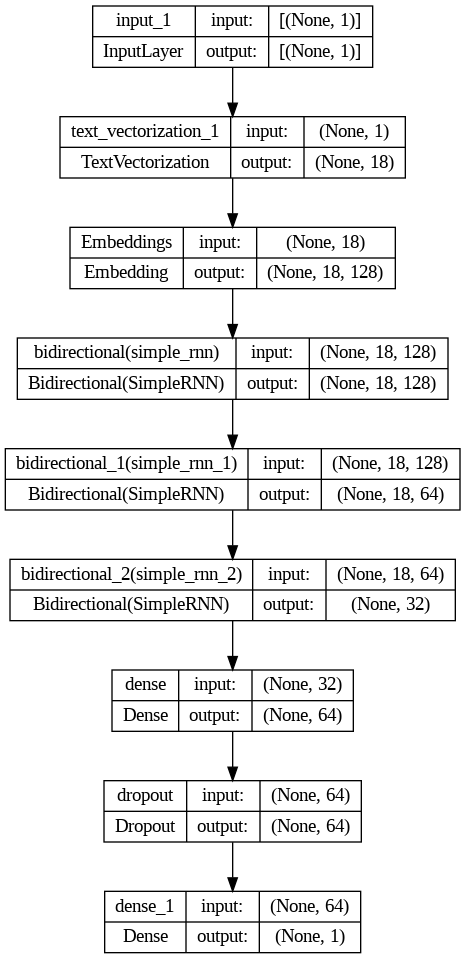

In [ ]:
plot_model(model_1, show_shapes=True)

In [ ]:
model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

In [ ]:
history_1 = model_1.fit(train_dataset,
                        validation_data = test_dataset,
                        callbacks = create_tensorboard_callback("RNN_model"),
                        class_weight = weights,
                        epochs = 5)

Epoch 1/5
248/248 [==============================] - 72s 229ms/step - loss: 0.5304 - accuracy: 0.8840 - val_loss: 0.1769 - val_accuracy: 0.9344
Epoch 2/5
248/248 [==============================] - 27s 110ms/step - loss: 0.1936 - accuracy: 0.9635 - val_loss: 0.1998 - val_accuracy: 0.9321
Epoch 3/5
248/248 [==============================] - 35s 143ms/step - loss: 0.0877 - accuracy: 0.9851 - val_loss: 0.2721 - val_accuracy: 0.9084
Epoch 4/5
248/248 [==============================] - 29s 118ms/step - loss: 0.0494 - accuracy: 0.9922 - val_loss: 0.2828 - val_accuracy: 0.9308
Epoch 5/5
248/248 [==============================] - 37s 149ms/step - loss: 0.0322 - accuracy: 0.9950 - val_loss: 0.3524 - val_accuracy: 0.9265


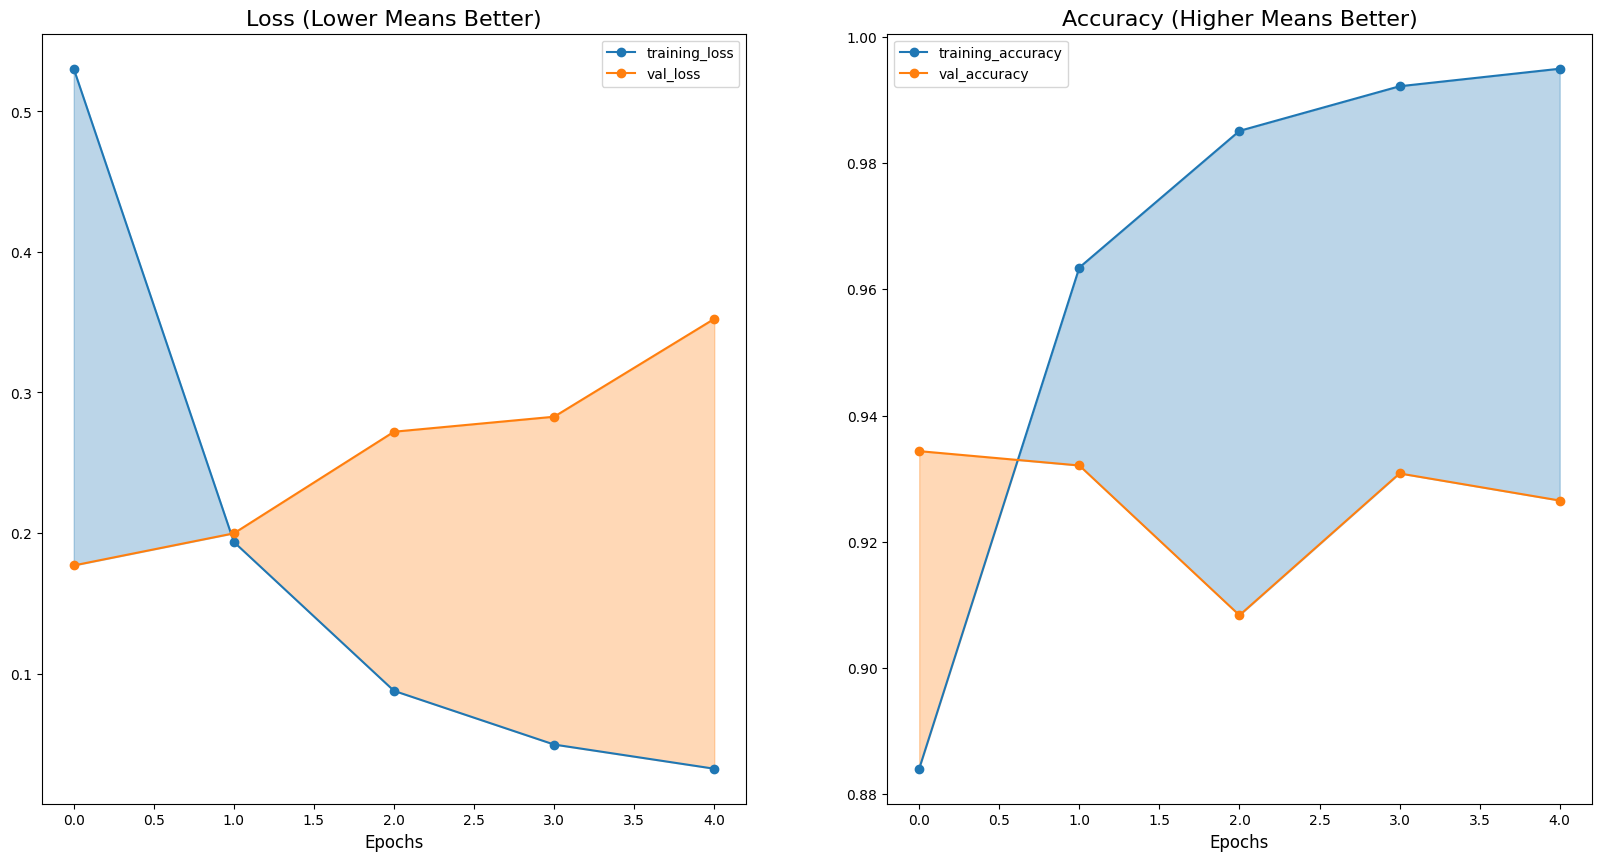

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_pred_probs = model_1.predict(test_dataset, verbose=1)
model_pred_probs

62/62 [==============================] - 1s 11ms/step


array([[5.1226580e-01],
       [2.0940175e-04],
       [4.9749556e-06],
       ...,
       [9.9990380e-01],
       [9.9990392e-01],
       [2.0430696e-06]], dtype=float32)

In [ ]:
model_preds = np.round(model_pred_probs)
model_preds[:5]

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [ ]:
model_1_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_1_results

{'accuracy': 92.65337036101995,
 'precision': 0.9265579040122001,
 'recall': 0.9265337036101995,
 'f1': 0.9265197224049825}

Confusion Matrix


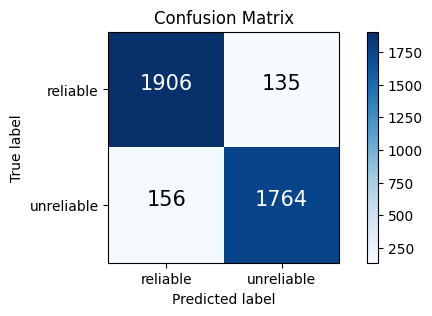

In [ ]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [ ]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2041
           1       0.93      0.92      0.92      1920

    accuracy                           0.93      3961
   macro avg       0.93      0.93      0.93      3961
weighted avg       0.93      0.93      0.93      3961



ClassWise Accuracy


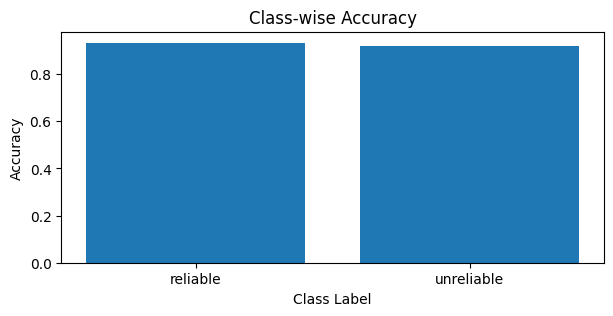

In [ ]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# LSTM with Bidirectional

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
text_vectors = vectorize_layer(input_layer)
token_embeddings = token_embed(text_vectors)
x = Bidirectional(LSTM(64, return_sequences=True))(token_embeddings)
x = Bidirectional(LSTM(16))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_2 = Model(inputs = input_layer,
                outputs = output_layer)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 Embeddings (Embedding)      (None, 18, 128)           1024000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 18, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                           

In [ ]:
model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

In [ ]:
history_2 = model_2.fit(train_dataset,
                        validation_data = test_dataset,
                        callbacks = create_tensorboard_callback("LSTM_model"),
                        class_weight = weights,
                        epochs = 5)

Epoch 1/5
248/248 [==============================] - 30s 74ms/step - loss: 0.2444 - accuracy: 0.9640 - val_loss: 0.1942 - val_accuracy: 0.9361
Epoch 2/5
248/248 [==============================] - 3s 12ms/step - loss: 0.0588 - accuracy: 0.9913 - val_loss: 0.3358 - val_accuracy: 0.9275
Epoch 3/5
248/248 [==============================] - 3s 14ms/step - loss: 0.0399 - accuracy: 0.9936 - val_loss: 0.3089 - val_accuracy: 0.9326
Epoch 4/5
248/248 [==============================] - 3s 12ms/step - loss: 0.0343 - accuracy: 0.9948 - val_loss: 0.3247 - val_accuracy: 0.9331
Epoch 5/5
248/248 [==============================] - 3s 12ms/step - loss: 0.0207 - accuracy: 0.9977 - val_loss: 0.3963 - val_accuracy: 0.9336


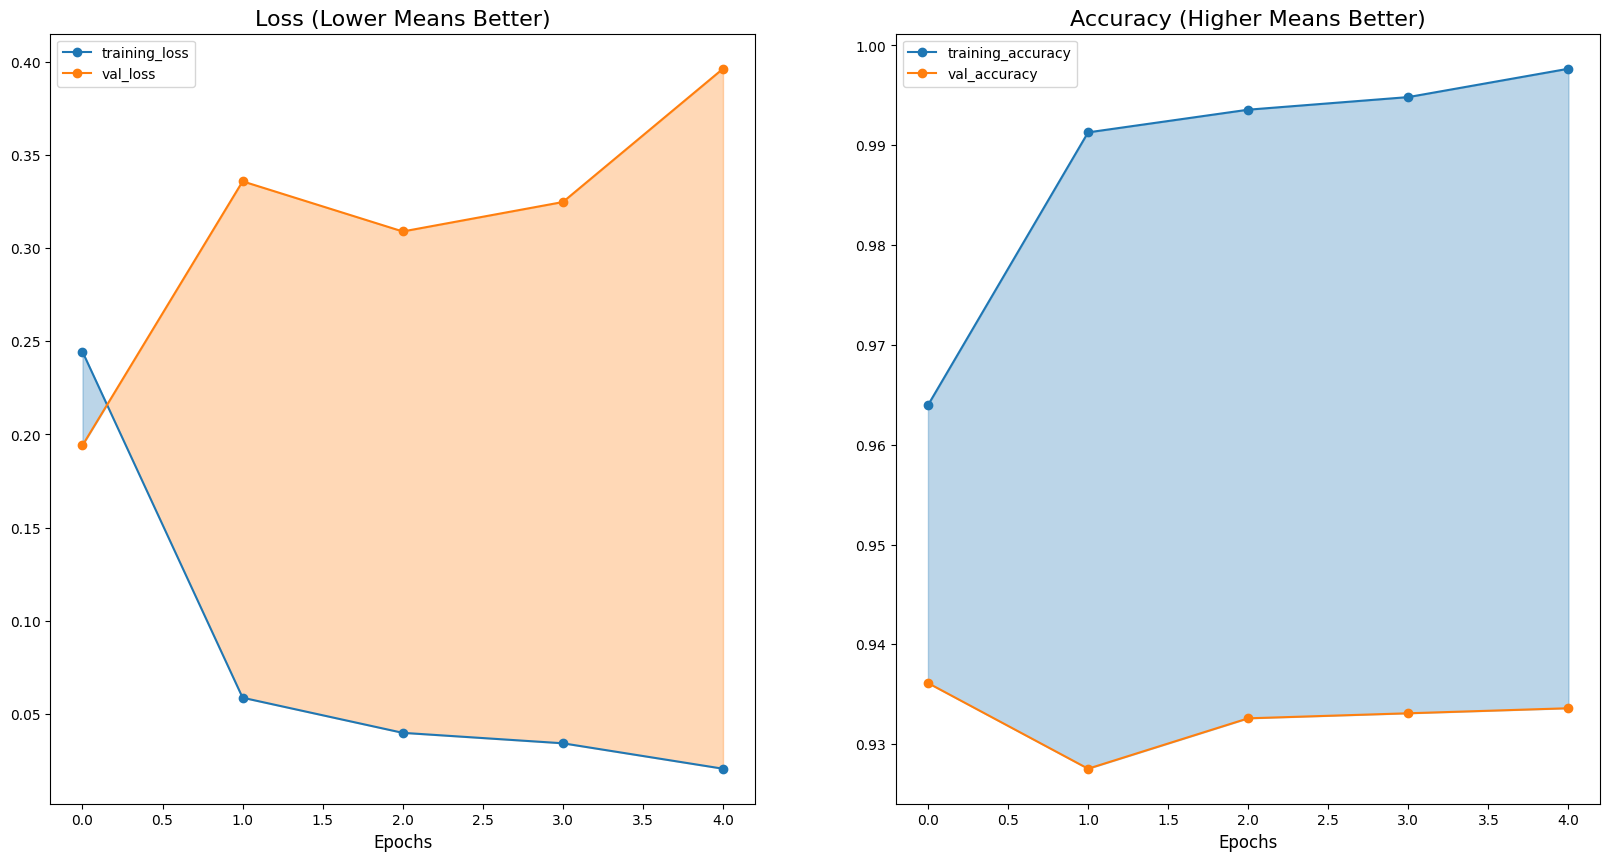

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_pred_probs = model_2.predict(test_dataset, verbose=1)
model_pred_probs

62/62 [==============================] - 2s 5ms/step


array([[3.9555631e-05],
       [7.5729786e-06],
       [3.1785555e-06],
       ...,
       [9.9995804e-01],
       [9.9982411e-01],
       [5.7316634e-06]], dtype=float32)

In [ ]:
model_preds = np.round(model_pred_probs)
model_preds[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [ ]:
model_2_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_2_results

{'accuracy': 93.36026255995961,
 'precision': 0.9343735156922758,
 'recall': 0.9336026255995961,
 'f1': 0.9336166688110161}

Confusion Matrix


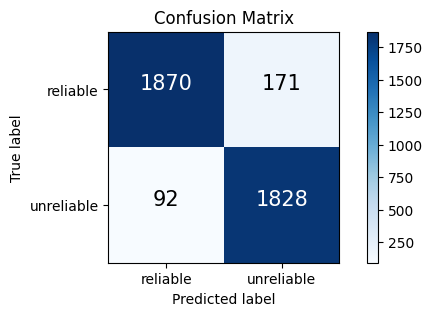

In [ ]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [ ]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2041
           1       0.91      0.95      0.93      1920

    accuracy                           0.93      3961
   macro avg       0.93      0.93      0.93      3961
weighted avg       0.93      0.93      0.93      3961



ClassWise Accuracy


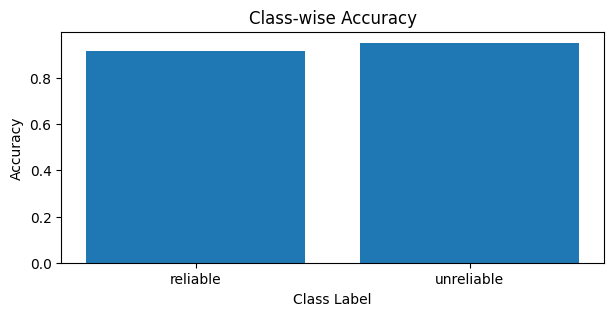

In [ ]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# GRU With Bidirectional

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
text_vectors = vectorize_layer(input_layer)
token_embeddings = token_embed(text_vectors)
x = Bidirectional(GRU(64, return_sequences=True))(token_embeddings)
x = Bidirectional(GRU(32))(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs = input_layer,
                         outputs = output_layer)
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 Embeddings (Embedding)      (None, 18, 128)           1024000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 18, 128)          74496     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                           

In [ ]:
model_3.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

In [ ]:
history_3 = model_3.fit(train_dataset,
                        validation_data = test_dataset,
                        callbacks = create_tensorboard_callback("GRU_model"),
                        class_weight = weights,
                        epochs = 5)

Epoch 1/5
248/248 [==============================] - 26s 72ms/step - loss: 0.1928 - accuracy: 0.9707 - val_loss: 0.3859 - val_accuracy: 0.9344
Epoch 2/5
248/248 [==============================] - 3s 11ms/step - loss: 0.0348 - accuracy: 0.9943 - val_loss: 0.4498 - val_accuracy: 0.9351
Epoch 3/5
248/248 [==============================] - 3s 12ms/step - loss: 0.0160 - accuracy: 0.9967 - val_loss: 0.7055 - val_accuracy: 0.9298
Epoch 4/5
248/248 [==============================] - 4s 14ms/step - loss: 0.0247 - accuracy: 0.9956 - val_loss: 0.5360 - val_accuracy: 0.9301
Epoch 5/5
248/248 [==============================] - 3s 12ms/step - loss: 0.0142 - accuracy: 0.9969 - val_loss: 0.6538 - val_accuracy: 0.9164


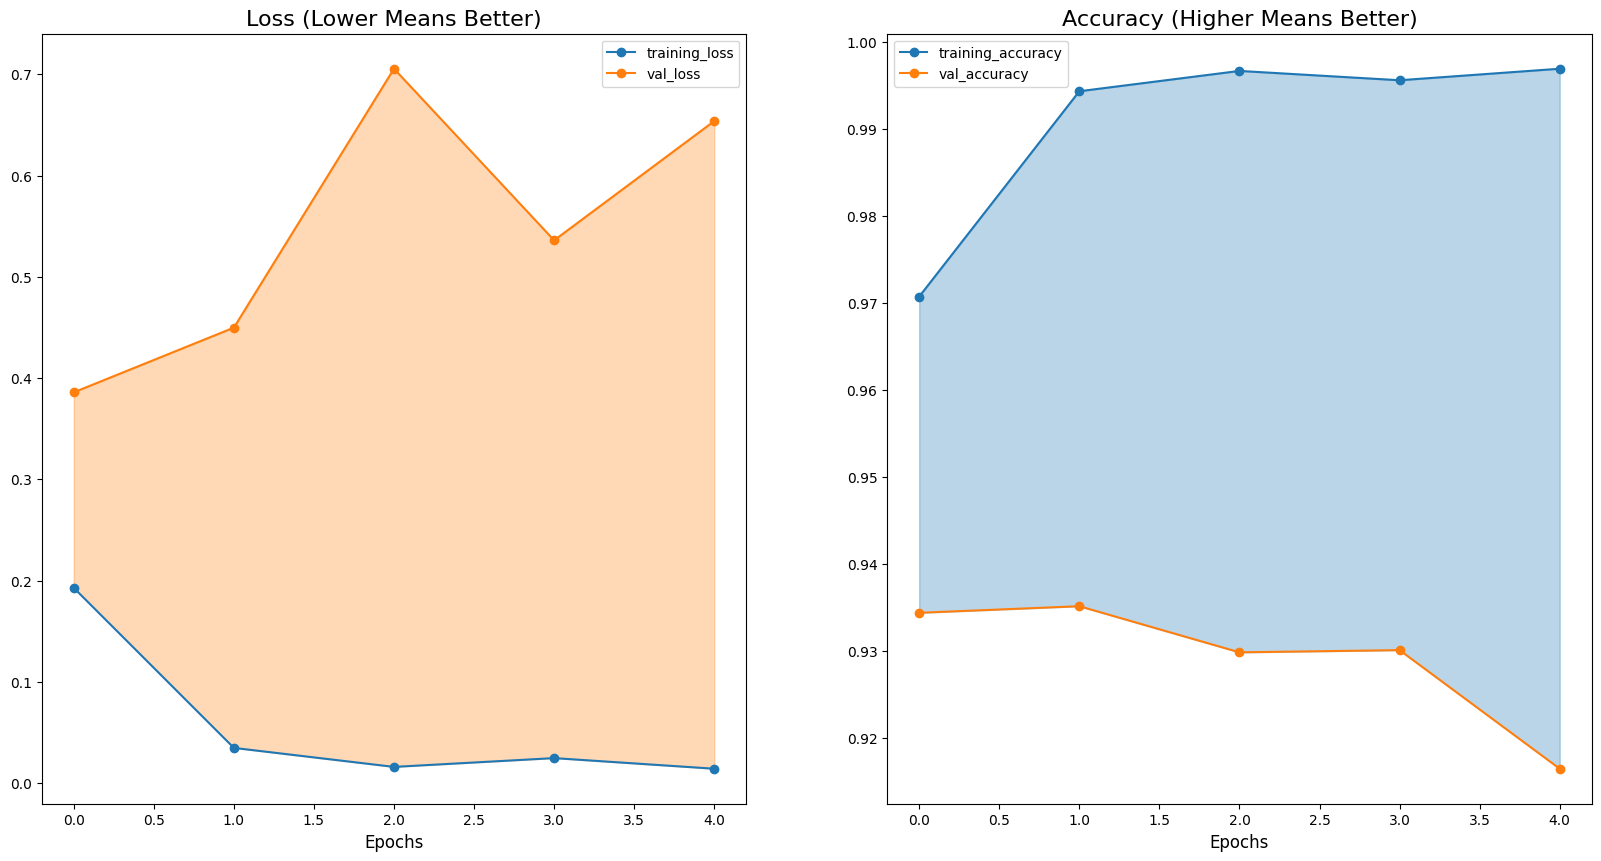

In [ ]:
plot_loss_curves(history_3)

In [ ]:
model_pred_probs = model_3.predict(test_dataset, verbose=1)
model_pred_probs

62/62 [==============================] - 1s 4ms/step


array([[8.6084032e-07],
       [3.7853409e-09],
       [6.4028516e-10],
       ...,
       [1.0000000e+00],
       [9.9999738e-01],
       [4.1937320e-09]], dtype=float32)

In [ ]:
model_preds = np.round(model_pred_probs)
model_preds[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [ ]:
model_3_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_3_results

{'accuracy': 91.6435243625347,
 'precision': 0.9172761547218674,
 'recall': 0.9164352436253471,
 'f1': 0.9163256250356062}

Confusion Matrix


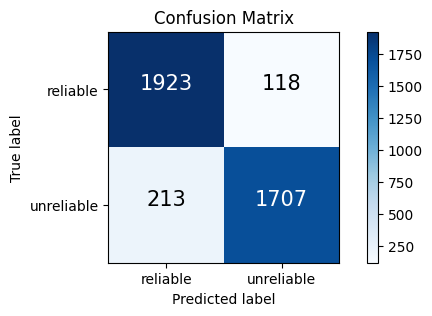

In [ ]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [ ]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2041
           1       0.94      0.89      0.91      1920

    accuracy                           0.92      3961
   macro avg       0.92      0.92      0.92      3961
weighted avg       0.92      0.92      0.92      3961



ClassWise Accuracy


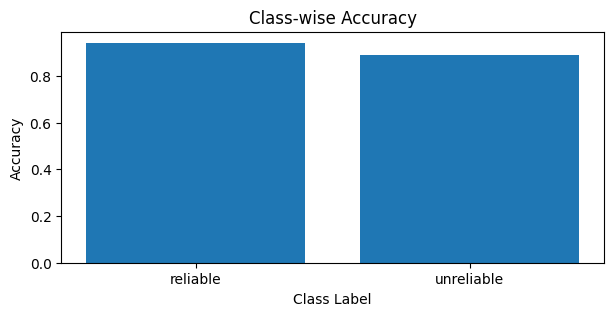

In [ ]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# Conv1D Model

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
text_vectors = vectorize_layer(input_layer)
token_embeddings = token_embed(text_vectors)
x = Conv1D(32, 3, activation='relu')(token_embeddings)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs = input_layer,
                         outputs = output_layer)
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 Embeddings (Embedding)      (None, 18, 128)           1024000   
                                                                 
 conv1d (Conv1D)             (None, 16, 32)            12320     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 32)                16416     
                                                           

In [ ]:
model_4.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

In [ ]:
history_4 = model_4.fit(train_dataset,
                        validation_data = test_dataset,
                        callbacks = create_tensorboard_callback("Conv_model"),
                        class_weight = weights,
                        epochs = 5)

Epoch 1/5
248/248 [==============================] - 35s 100ms/step - loss: 0.1624 - accuracy: 0.9771 - val_loss: 0.3024 - val_accuracy: 0.9306
Epoch 2/5
248/248 [==============================] - 2s 7ms/step - loss: 0.0132 - accuracy: 0.9986 - val_loss: 0.4047 - val_accuracy: 0.9318
Epoch 3/5
248/248 [==============================] - 1s 6ms/step - loss: 0.0076 - accuracy: 0.9991 - val_loss: 0.4779 - val_accuracy: 0.9321
Epoch 4/5
248/248 [==============================] - 2s 8ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.5438 - val_accuracy: 0.9339
Epoch 5/5
248/248 [==============================] - 3s 10ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.5972 - val_accuracy: 0.9316


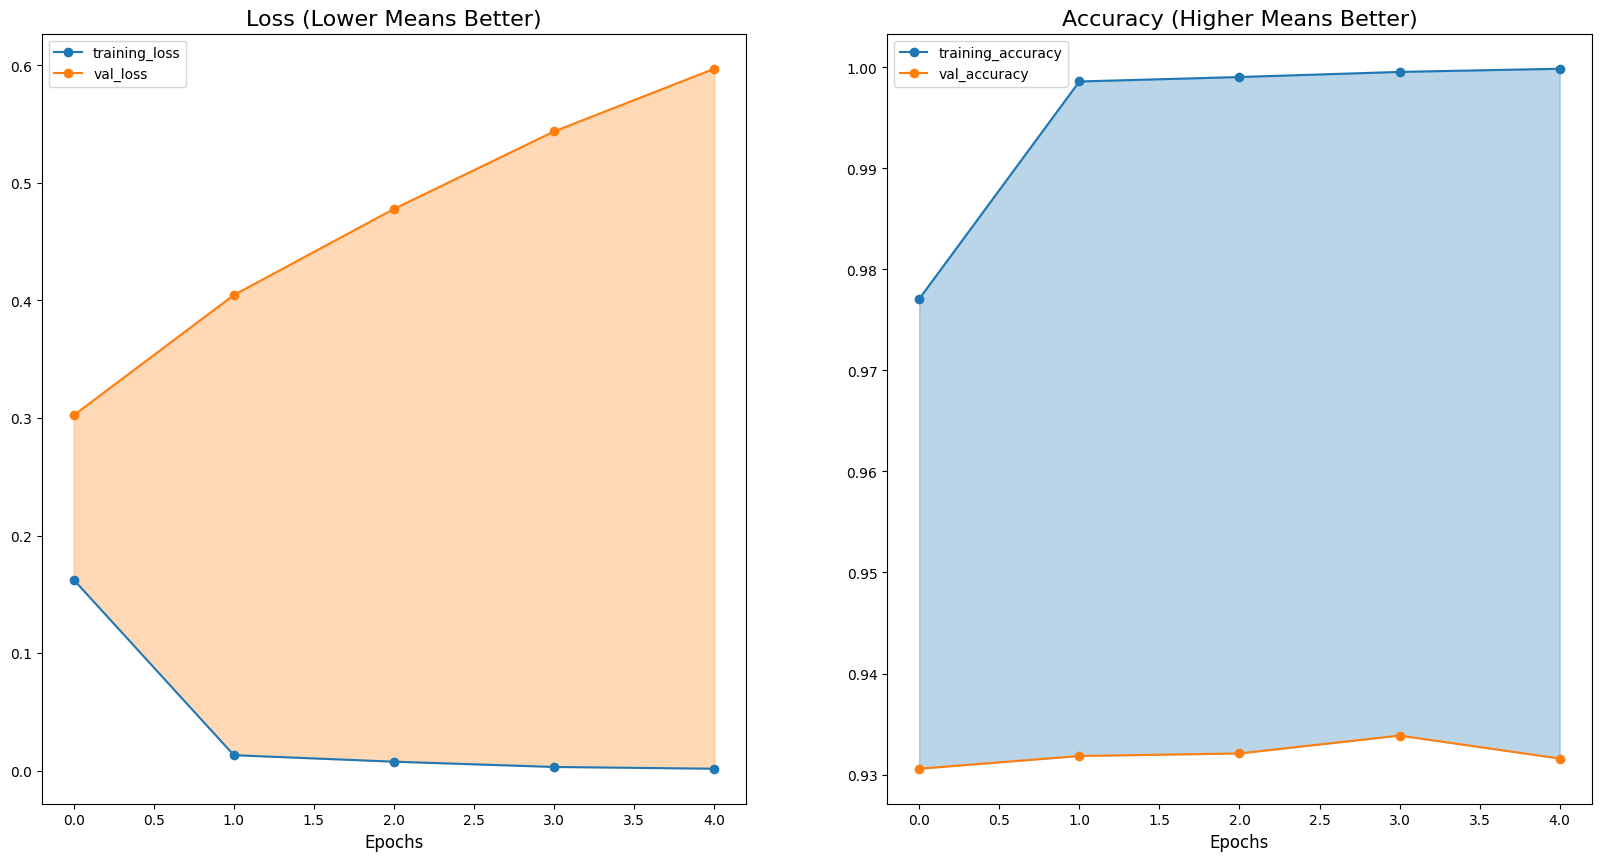

In [ ]:
plot_loss_curves(history_4)

In [ ]:
model_pred_probs = model_4.predict(test_dataset, verbose=1)
model_pred_probs

62/62 [==============================] - 0s 2ms/step


array([[6.3379273e-05],
       [4.4951216e-11],
       [1.2407410e-13],
       ...,
       [1.0000000e+00],
       [9.9998355e-01],
       [4.5440839e-08]], dtype=float32)

In [ ]:
model_preds = np.round(model_pred_probs)
model_preds[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [ ]:
model_4_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_4_results

{'accuracy': 93.15829336026256,
 'precision': 0.9323166146020122,
 'recall': 0.9315829336026256,
 'f1': 0.9315977094282836}

Confusion Matrix


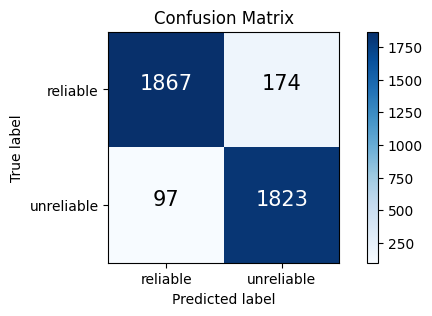

In [ ]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [ ]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2041
           1       0.91      0.95      0.93      1920

    accuracy                           0.93      3961
   macro avg       0.93      0.93      0.93      3961
weighted avg       0.93      0.93      0.93      3961



ClassWise accuracy


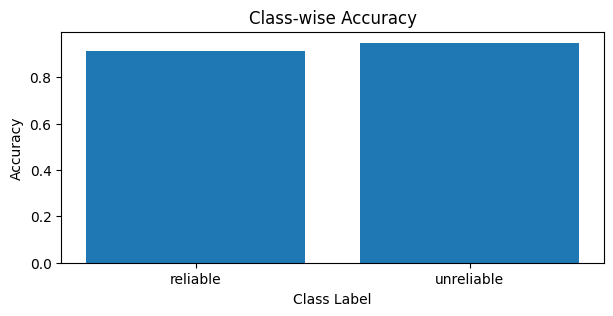

In [ ]:
print("ClassWise accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# Training our own word2vec embedding model

In [ ]:
! pip install gensim

In [ ]:
import gensim
import os

In [ ]:
from gensim.utils import simple_preprocess

sentences = []
for sentence in train_sentences:   # instead train on train_sentences train on entire dataframe
  sentences.append(simple_preprocess(sentence))

In [ ]:
model = gensim.models.Word2Vec(window=10,
                               min_count=2)

In [ ]:
model.build_vocab(sentences)

In [ ]:
model.train(sentences, total_examples = model.corpus_count, epochs = model.epochs)

(687218, 921810)

In [ ]:
model.wv.most_similar('fake')

[('network', 0.9965169429779053),
 ('fox', 0.9962426424026489),
 ('redflag', 0.995336651802063),
 ('daily', 0.9949077367782593),
 ('america', 0.9929952025413513),
 ('cnn', 0.9918586611747742),
 ('secretly', 0.9896401166915894),
 ('wapo', 0.9894880056381226),
 ('november', 0.988447904586792),
 ('websites', 0.9882077574729919)]

In [ ]:
model.wv.doesnt_match(['facebook','twitter','youtube','whatsapp'])

'whatsapp'

In [ ]:
model.wv['facebook'].shape

(100,)

In [ ]:
model.wv.similarity('facebook','twitter')

0.9911396

In [ ]:
model.wv.get_normed_vectors().shape

(10130, 100)

In [ ]:
model.wv.index_to_key[:5]

['the', 'new', 'york', 'times', 'to']

In [ ]:
def first_cap(word):
  return word[0].upper() + word[1:]

In [ ]:
pretrained_embeddings = []
EMBEDDING_DIM = 100

for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(model.wv.get_vector(vectorize_layer.get_vocabulary()[i]))
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(model.wv.get_vector(first_cap(vectorize_layer.get_vocabulary()[i])))
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))
  if i%1000==0:
    print('iis====================================',i)


nosolution
iis==================================== 0
[UNK]
nosolution
a
nosolution
s
nosolution
u
nosolution
–
nosolution
i
nosolution
—
nosolution
n
nosolution
f
nosolution
t
nosolution
g
nosolution
p
nosolution
o
nosolution
c
nosolution
e
nosolution
в
nosolution
b
nosolution
l
nosolution
d
nosolution
”
nosolution
…
nosolution
m
nosolution
k
nosolution
iis==================================== 1000
y
nosolution
h
nosolution
»
nosolution
и
nosolution
j
nosolution
w
nosolution
“the
nosolution
v
nosolution
à
nosolution
“we
nosolution
r
nosolution
iis==================================== 2000
“if
nosolution
·
nosolution
«
nosolution
trump”
nosolution
о
nosolution
iis==================================== 3000
extraterrestrials
nosolution
“its
nosolution
“a
nosolution
с
nosolution
“i
nosolution
“f
nosolution
£
nosolution
x
nosolution
head”
nosolution
iis==================================== 4000
“you
nosolution
а
nosolution
counterterrorism
nosolution
⋆
nosolution
•
nosolution
“what
nosolution


In [ ]:
pretrained_embedding_array = np.array(pretrained_embeddings)

In [ ]:
print(pretrained_embedding_array.shape)

(10000, 100)


In [ ]:
np.save("/content/drive/MyDrive/Sentiment_Analysis_embeddings", pretrained_embedding_array)

In [ ]:
pretrained_embedding_array = np.load('/content/drive/MyDrive/Sentiment_Analysis_embeddings.npy', allow_pickle=True)

In [ ]:
print(pretrained_embedding_array.shape)

(10000,)


In [ ]:
word2vec_embed = Embedding(input_dim = 10000,
                           output_dim = 100,
                           embeddings_initializer = tf.keras.initializers.Constant(pretrained_embedding_array),
                           trainable = True,
                           name = "Word2Vec-Embedding")

In [ ]:
target_sentence = random.choice(train_sentences)
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = word2vec_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the american public can no longer deal with the limitless corruption of their government

Sentence after vectorization (before embedding):
[[  2  95 258  79  52 793 159  16   2   1 757   7  98 153   0   0   0   0]]

Sentence after embedding:
[[[-0.8008977   0.87280875  0.01641849 ... -0.8758476   0.00661717
    0.3452997 ]
  [-0.3265991   0.71256495  0.03917691 ... -0.7064454   0.2930109
    0.33011982]
  [-0.15527804  0.48780432  0.0398771  ... -0.48811176  0.2356994
    0.27044186]
  ...
  [ 2.2958107  -2.041153   -0.6144911  ... -0.47533318  0.24039215
   -0.86702895]
  [ 2.2958107  -2.041153   -0.6144911  ... -0.47533318  0.24039215
   -0.86702895]
  [ 2.2958107  -2.041153   -0.6144911  ... -0.47533318  0.24039215
   -0.86702895]]]

Embedded sentence shape: (1, 18, 100)


In [ ]:
input_layer = Input(shape=(1, ), dtype=tf.string)
text_vectors = vectorize_layer(input_layer)
token_embeddings = word2vec_embed(text_vectors)
x = Bidirectional(SimpleRNN(units=64, return_sequences=True))(token_embeddings)
x = Bidirectional(SimpleRNN(units=32))(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_5 = Model(inputs = input_layer,
                outputs = output_layer)
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 Word2Vec-Embedding (Embeddi  (None, 18, 100)          1000000   
 ng)                                                             
                                                                 
 bidirectional_9 (Bidirectio  (None, 18, 128)          21120     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 64)               10304     
 onal)                                                     

In [ ]:
model_5.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

In [ ]:
history_5 = model_5.fit(train_dataset,
                        validation_data = test_dataset,
                        callbacks = create_tensorboard_callback("Glove_Embeddings_model"),
                        class_weight = weights,
                        epochs = 5)

Epoch 1/5
248/248 [==============================] - 50s 175ms/step - loss: 0.8354 - accuracy: 0.7985 - val_loss: 0.2461 - val_accuracy: 0.8990
Epoch 2/5
248/248 [==============================] - 31s 126ms/step - loss: 0.4815 - accuracy: 0.8983 - val_loss: 0.2047 - val_accuracy: 0.9071
Epoch 3/5
248/248 [==============================] - 24s 95ms/step - loss: 0.3345 - accuracy: 0.9272 - val_loss: 0.2153 - val_accuracy: 0.9149
Epoch 4/5
248/248 [==============================] - 41s 167ms/step - loss: 0.1933 - accuracy: 0.9653 - val_loss: 0.2260 - val_accuracy: 0.9258
Epoch 5/5
248/248 [==============================] - 26s 105ms/step - loss: 0.1167 - accuracy: 0.9806 - val_loss: 0.2744 - val_accuracy: 0.8980


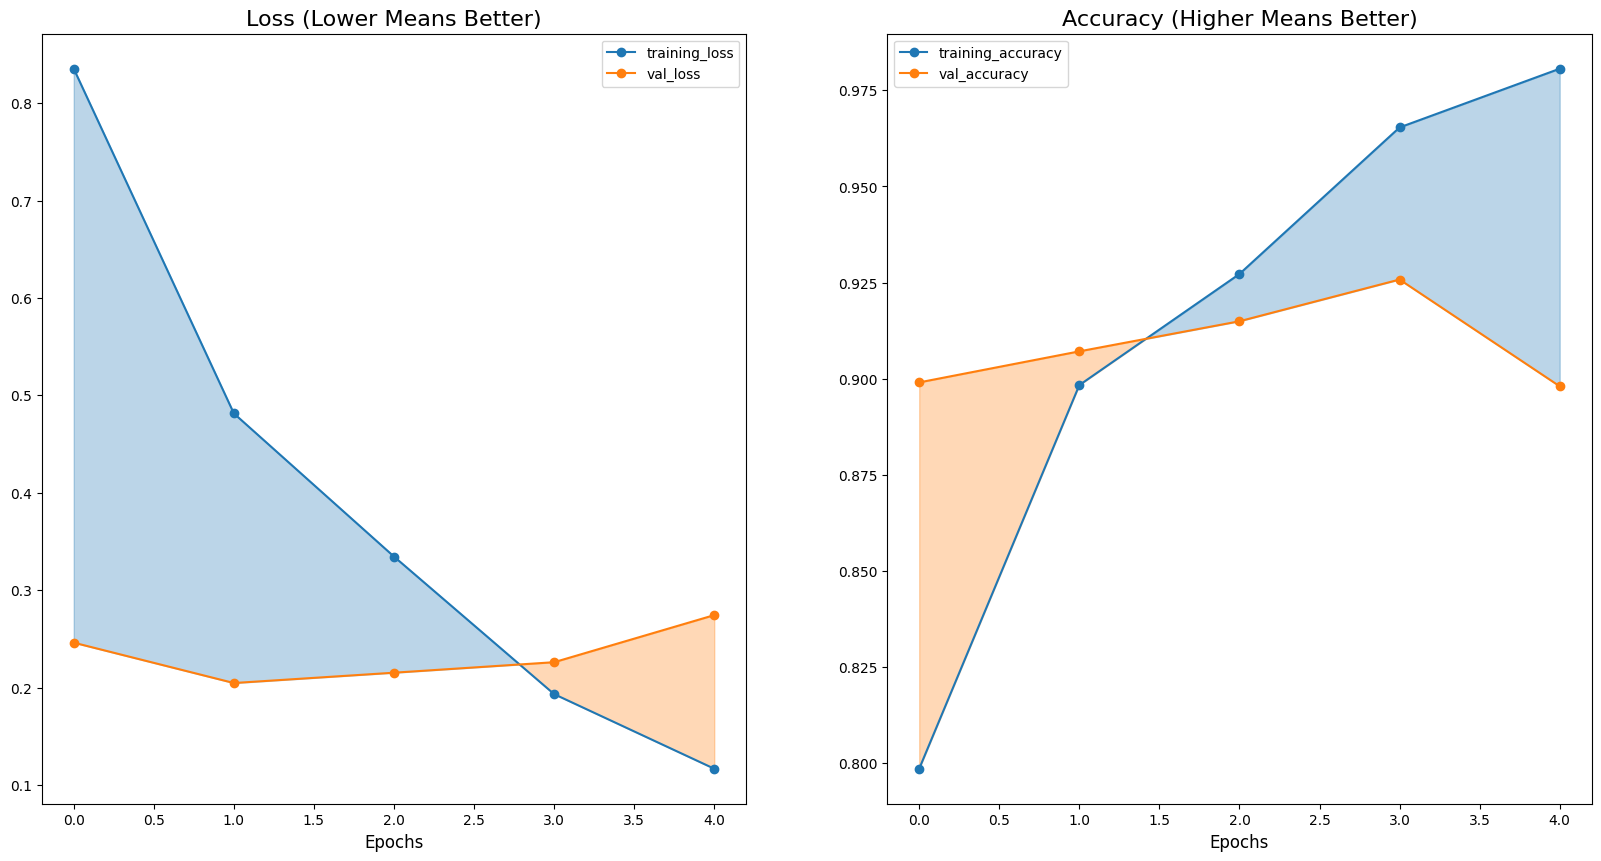

In [ ]:
plot_loss_curves(history_5)

In [ ]:
model_pred_probs = model_5.predict(test_dataset, verbose=1)
model_pred_probs

62/62 [==============================] - 1s 14ms/step


array([[9.9928111e-01],
       [9.2647818e-09],
       [6.8776840e-01],
       ...,
       [8.5606850e-08],
       [7.3322885e-02],
       [3.4063396e-07]], dtype=float32)

In [ ]:
model_preds = np.round(model_pred_probs)
model_preds[:5]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [ ]:
model_5_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_5_results

{'accuracy': 89.80055541529917,
 'precision': 0.8998946632132606,
 'recall': 0.8980055541529917,
 'f1': 0.897605214301203}

Confusion Matrix


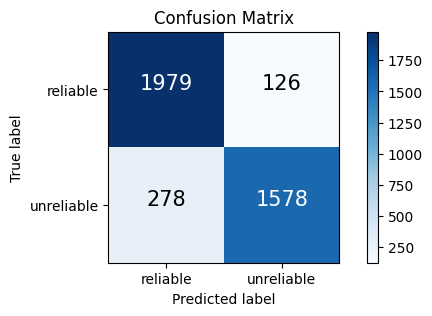

In [ ]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [ ]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2105
           1       0.93      0.85      0.89      1856

    accuracy                           0.90      3961
   macro avg       0.90      0.90      0.90      3961
weighted avg       0.90      0.90      0.90      3961



ClassWise Accuracy


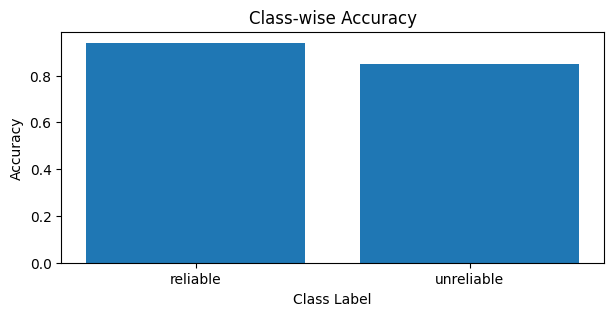

In [ ]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# Using Pretrained word2vec embeddings

In [ ]:
import gensim.downloader as api

In [ ]:
word2vec = api.load('word2vec-google-news-300')

[=================================================-] 99.9% 1660.9/1662.8MB downloaded


In [ ]:
word2vec.vectors.shape

(3000000, 300)

In [ ]:
len(word2vec['The'])

300

In [ ]:
word2vec.most_similar('Man')

[('Woman', 0.6939345002174377),
 ('Boy', 0.5896925330162048),
 ('Girl', 0.584598958492279),
 ('Suspect', 0.5577560067176819),
 ('Couple', 0.5528685450553894),
 ('man', 0.5316051840782166),
 ('Robber', 0.5315312743186951),
 ('Teenager', 0.5161930322647095),
 ('depicts_Michelangelo_Creation', 0.5148172378540039),
 ('Policeman', 0.5136396884918213)]

In [ ]:
vectorize_layer.get_vocabulary()[2]

'the'

In [ ]:
def first_cap(word):
  return word[0].upper() + word[1:]

In [ ]:
word2vec[vectorize_layer.get_vocabulary()[3]].shape

(300,)

In [ ]:
pretrained_embeddings = []
EMBEDDING_DIM = 300

for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_cap(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))
  if i%1000 == 0:
    print('iis====================================',i)


nosolution
iis==================================== 0
[UNK]
nosolution
to
toupper
of
toupper
a
toupper
and
toupper
breitbart
toupper
–
nosolution
—
nosolution
comey
toupper
aleppo
toupper
mosul
toupper
brexit
nosolution
hillarys
toupper
podesta
toupper
truthfeed
nosolution
bannon
toupper
megyn
toupper
”
nosolution
gorsuch
toupper
doesnt
nosolution
zika
toupper
gorafi
nosolution
didnt
nosolution
vladimir
toupper
doj
nosolution
isnt
nosolution
melania
toupper
обозрение
nosolution
новое
nosolution
восточное
nosolution
…
nosolution
abedin
toupper
duterte
toupper
spicer
toupper
kushner
toupper
cnns
nosolution
tillerson
toupper
iis==================================== 1000
kaepernick
toupper
assad
toupper
ryans
toupper
russias
toupper
flynn
toupper
delingpole
toupper
endingfed
nosolution
erdogan
toupper
comeys
nosolution
netanyahu
toupper
“the
nosolution
не
nosolution
schumer
toupper
ivanka
toupper
dapl
nosolution
saudis
toupper
fbis
nosolution
blasio
toupper
wasnt
nosolution
merkel
toupper
k

In [ ]:
pretrained_embedding_array = np.array(pretrained_embeddings)

In [ ]:
print(pretrained_embedding_array.shape)

(10000, 300)


In [ ]:
np.save("/content/drive/MyDrive/Sentiment_Analysis_embeddings", pretrained_embedding_array)

In [ ]:
pretrained_embedding_array = np.load('/content/drive/MyDrive/Sentiment_Analysis_embeddings.npy')

In [ ]:
print(pretrained_embedding_array.shape)

In [ ]:
word2vec_embed = Embedding(input_dim = 10000,
                           output_dim = 300,
                           embeddings_initializer = tf.keras.initializers.Constant(pretrained_embedding_array),
                           trainable = True,
                           name = "Word2Vec-Embedding")

In [ ]:
target_sentence = random.choice(train_sentences)
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = word2vec_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
death of irans rafsanjani removes influential voice against hard liners the new york times

Sentence after vectorization (before embedding):
[[ 196    7 2492 4917 2673 4350  717   77  568 6411    2    3    4    5
     0    0    0    0]]

Sentence after embedding:
[[[-0.04467773  0.05712891  0.328125   ... -0.0625     -0.078125
    0.28710938]
  [ 0.125      -0.09521484  0.03112793 ...  0.00405884  0.05493164
   -0.11914062]
  [-0.10107422  0.28125     0.5        ...  0.05419922  0.02758789
    0.30273438]
  ...
  [ 1.1393282  -0.02369132 -1.34723    ...  0.19179426 -0.0433607
   -0.691416  ]
  [ 1.1393282  -0.02369132 -1.34723    ...  0.19179426 -0.0433607
   -0.691416  ]
  [ 1.1393282  -0.02369132 -1.34723    ...  0.19179426 -0.0433607
   -0.691416  ]]]

Embedded sentence shape: (1, 18, 300)


In [ ]:
input_layer = Input(shape=(1, ), dtype=tf.string)
text_vectors = vectorize_layer(input_layer)
token_embeddings = token_embed(text_vectors)
x = Bidirectional(SimpleRNN(units=64, return_sequences=True))(token_embeddings)
x = Bidirectional(SimpleRNN(units=32))(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_6 = Model(inputs = input_layer,
                outputs = output_layer)
model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 18)               0         
 ectorization)                                                   
                                                                 
 Embeddings (Embedding)      (None, 18, 128)           1280000   
                                                                 
 bidirectional_11 (Bidirecti  (None, 18, 128)          24704     
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 64)               10304     
 onal)                                                           
                                                           

In [ ]:
model_6.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

In [ ]:
history_6 = model_6.fit(train_dataset,
                        validation_data = test_dataset,
                        callbacks = create_tensorboard_callback("Glove_Pretrained_Embeddings"),
                        class_weight = weights,
                        epochs = 5)

Epoch 1/5
248/248 [==============================] - 47s 162ms/step - loss: 0.6217 - accuracy: 0.8626 - val_loss: 0.1800 - val_accuracy: 0.9233
Epoch 2/5
248/248 [==============================] - 22s 88ms/step - loss: 0.2678 - accuracy: 0.9524 - val_loss: 0.2075 - val_accuracy: 0.9270
Epoch 3/5
248/248 [==============================] - 20s 81ms/step - loss: 0.1425 - accuracy: 0.9803 - val_loss: 0.2120 - val_accuracy: 0.9265
Epoch 4/5
248/248 [==============================] - 22s 88ms/step - loss: 0.0772 - accuracy: 0.9900 - val_loss: 0.3043 - val_accuracy: 0.9222
Epoch 5/5
248/248 [==============================] - 20s 83ms/step - loss: 0.0449 - accuracy: 0.9951 - val_loss: 0.3906 - val_accuracy: 0.9129


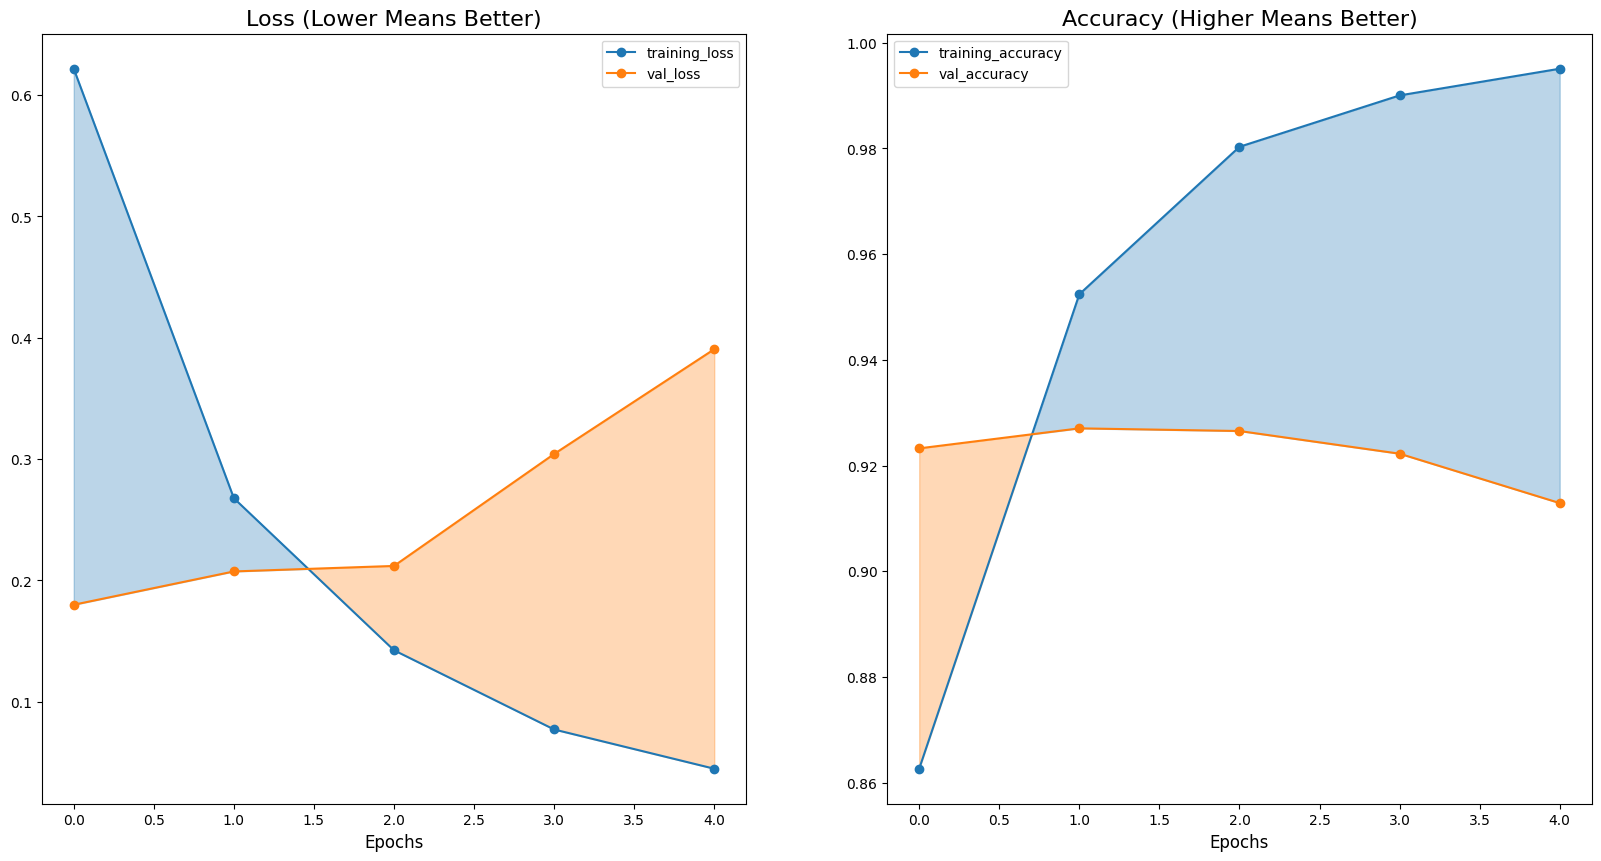

In [ ]:
plot_loss_curves(history_6)

In [ ]:
model_pred_probs = model_6.predict(test_dataset, verbose=1)
model_pred_probs

62/62 [==============================] - 1s 9ms/step


array([[9.9806792e-01],
       [4.5967454e-07],
       [9.9278885e-01],
       ...,
       [3.6061928e-04],
       [4.7946731e-03],
       [3.6242598e-06]], dtype=float32)

In [ ]:
model_preds = np.round(model_pred_probs)
model_preds[:5]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [ ]:
model_6_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_6_results

{'accuracy': 91.29007826306488,
 'precision': 0.9136322303881558,
 'recall': 0.9129007826306488,
 'f1': 0.9127130330773724}

Confusion Matrix


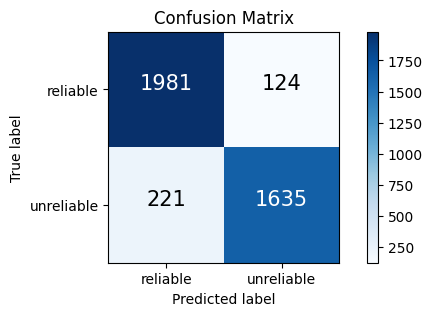

In [ ]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [ ]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2105
           1       0.93      0.88      0.90      1856

    accuracy                           0.91      3961
   macro avg       0.91      0.91      0.91      3961
weighted avg       0.91      0.91      0.91      3961



ClassWise Accuracy


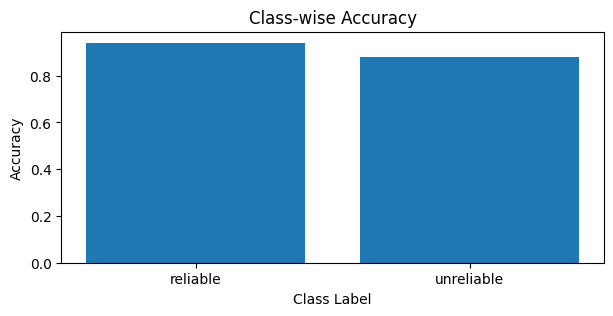

In [ ]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# Most Wrong Predictions

In [ ]:
model_pred_probs = model_2.predict(df['title'], verbose=1)
model_pred_probs

619/619 [==============================] - 4s 5ms/step


array([[0.99988127],
       [0.99990165],
       [0.99994576],
       ...,
       [0.99992883],
       [0.9998692 ],
       [0.99989724]], dtype=float32)

In [ ]:
model_preds = np.round(model_pred_probs)
model_preds[:5]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
df['Prediction'] = model_preds
df['Preds_prob'] = tf.reduce_max(model_pred_probs, axis=1).numpy()
df['Correct'] = df['Prediction'] == df['label']
df.head(5)

,title,label,Prediction,Preds_prob,Correct
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,1.0,0.999881,True
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0,1.0,0.999902,False
2,Why the Truth Might Get You Fired,1,1.0,0.999946,True
3,15 Civilians Killed In Single US Airstrike Hav...,1,1.0,0.999899,True
4,Iranian woman jailed for fictional unpublished...,1,1.0,0.999958,True


In [ ]:
top_10_wrong = df[df['Correct'] == False].sort_values("Preds_prob", ascending=False)[:10]

In [ ]:
top_10_wrong

,title,label,Prediction,Preds_prob,Correct
1465,"Now the European Union Wants ""Build A Wall"" – ...",0,1.0,0.999968,False
10550,Assad: America’s ’Deep State’ – Not Trump – Bl...,0,1.0,0.999965,False
1215,"At Rio Olympics, the National Anthem Sounds … ...",0,1.0,0.999964,False
14875,What if the Senate Goes Beyond the Filibuster ...,0,1.0,0.999962,False
6523,FULL TEXT: MILO on why the Democrats Lost the ...,0,1.0,0.999962,False
13435,Assaults on Border Patrol Agents Continue – 3 ...,0,1.0,0.999962,False
14408,How the #Resistance Could Win the House for De...,0,1.0,0.999961,False
1160,McConnell on if Mexico Will Pay for the Border...,0,1.0,0.999961,False
4510,Saudis and Extremism: ‘Both the Arsonists and ...,0,1.0,0.999960,False
2492,What the Election Means for the Markets - The ...,0,1.0,0.999960,False


# Model at inference

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices([["House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It"],
                                              ["American Drivers Regain Appetite for Gas Guzzlers - The New York Times"]])


In [ ]:
model_pred_probs = model_6.predict(test_data)

2/2 [==============================] - 0s 12ms/step


In [ ]:
model_preds = np.round(model_pred_probs)
model_preds

array([[1.],
       [1.]], dtype=float32)

In [ ]:
[class_labels[int(pred)] for pred in model_preds]

['unreliable', 'unreliable']

# Performance analysis

In [ ]:
models_result = pd.DataFrame({
    'RNN-Bidirectional': model_1_results,
    'LSTM-Bidirectional': model_2_results,
    'GRU-Bidirectional': model_3_results,
    'Conv-1D-Model': model_4_results,
    'RNN-Trained': model_5_results,
    'RNN-Pretrained': model_6_results,

})

models_result = models_result.transpose()
models_result['accuracy'] = models_result['accuracy'] / 100
models_result

,accuracy,precision,recall,f1
RNN-Bidirectional,0.926534,0.926558,0.926534,0.926520
LSTM-Bidirectional,0.933603,0.934374,0.933603,0.933617
GRU-Bidirectional,0.916435,0.917276,0.916435,0.916326
Conv-1D-Model,0.931583,0.932317,0.931583,0.931598
RNN-Trained,0.898006,0.899895,0.898006,0.897605
RNN-Pretrained,0.912901,0.913632,0.912901,0.912713


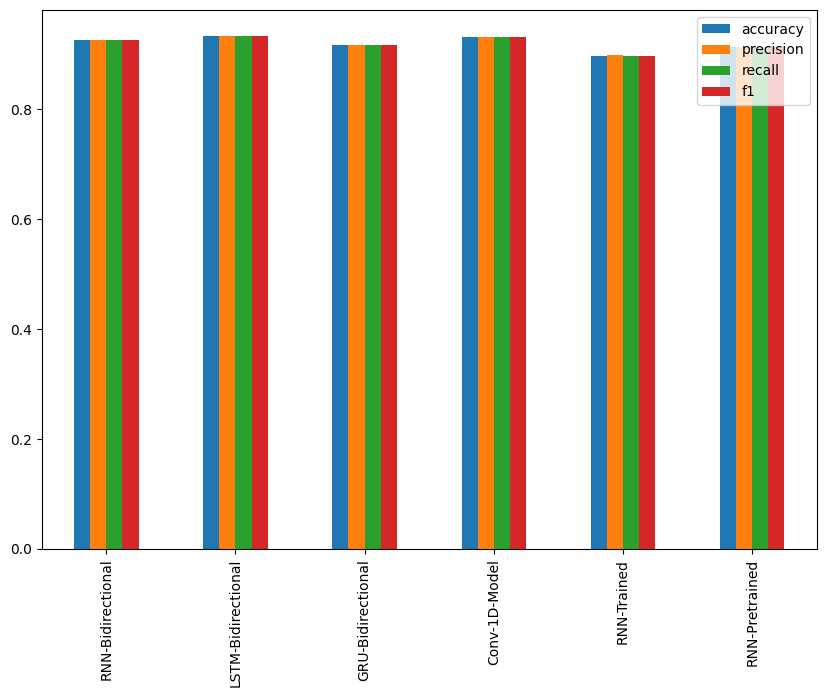

In [ ]:
models_result.plot(kind='bar', figsize=(10, 7));

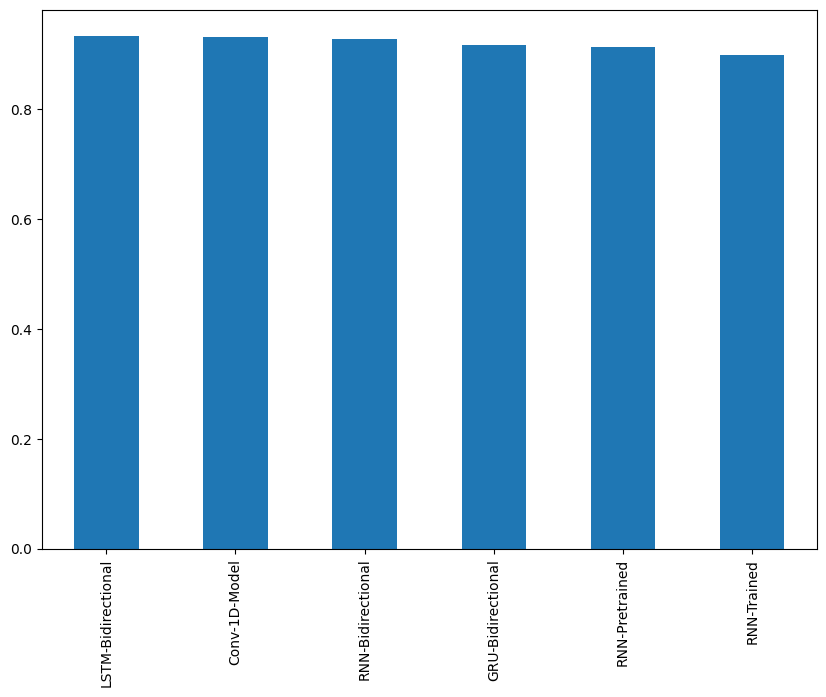

In [ ]:
models_result.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Model saving

In [ ]:
model_2.save("Fake_news_Classification_model")

In [ ]:
%cp -av /content/Fake_news_Classification_model /content/drive/MyDrive/Fakenewsclassification/

'/content/Fake_news_Classification_model' -> '/content/drive/MyDrive/Fakenewsclassification/Fake_news_Classification_model'
'/content/Fake_news_Classification_model/variables' -> '/content/drive/MyDrive/Fakenewsclassification/Fake_news_Classification_model/variables'
'/content/Fake_news_Classification_model/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/Fakenewsclassification/Fake_news_Classification_model/variables/variables.data-00000-of-00001'
'/content/Fake_news_Classification_model/variables/variables.index' -> '/content/drive/MyDrive/Fakenewsclassification/Fake_news_Classification_model/variables/variables.index'
'/content/Fake_news_Classification_model/assets' -> '/content/drive/MyDrive/Fakenewsclassification/Fake_news_Classification_model/assets'
'/content/Fake_news_Classification_model/fingerprint.pb' -> '/content/drive/MyDrive/Fakenewsclassification/Fake_news_Classification_model/fingerprint.pb'
'/content/Fake_news_Classification_model/saved_model.pb' -> 

In [ ]:
%cp -av /content/logs /content/drive/MyDrive/Fakenewsclassification

'/content/logs' -> '/content/drive/MyDrive/Fakenewsclassification'
'/content/logs/RNN_model_20230907-181619' -> '/content/drive/MyDrive/Fakenewsclassification/RNN_model_20230907-181619'
'/content/logs/RNN_model_20230907-181619/train' -> '/content/drive/MyDrive/Fakenewsclassification/RNN_model_20230907-181619/train'
'/content/logs/RNN_model_20230907-181619/train/events.out.tfevents.1694110579.e6bc7077d5c7.362.0.v2' -> '/content/drive/MyDrive/Fakenewsclassification/RNN_model_20230907-181619/train/events.out.tfevents.1694110579.e6bc7077d5c7.362.0.v2'
'/content/logs/RNN_model_20230907-181619/validation' -> '/content/drive/MyDrive/Fakenewsclassification/RNN_model_20230907-181619/validation'
'/content/logs/RNN_model_20230907-181619/validation/events.out.tfevents.1694110650.e6bc7077d5c7.362.1.v2' -> '/content/drive/MyDrive/Fakenewsclassification/RNN_model_20230907-181619/validation/events.out.tfevents.1694110650.e6bc7077d5c7.362.1.v2'
'/content/logs/LSTM_model_20230907-182121' -> '/content/dr

# Tensorboard

In [25]:
!kill 21042

/bin/bash: line 1: kill: (21042) - No such process


In [26]:
%load_ext tensorboard
%tensorboard --logdir /content/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6018), started 0:02:06 ago. (Use '!kill 6018' to kill it.)

<IPython.core.display.Javascript object>

# Hugging face model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=7ba71275f531e29f8d754fe5f3e61ca82fe94da7db1570a19e99509f03f2c5fa
  Stored in directory: /root/.cache/pip/whe

In [11]:
from huggingface_hub import notebook_login
notebook_login()

In [7]:
path = "/content/drive/MyDrive/Fakenewsclassification/Fake_news_Classification_model"
model = tf.keras.models.load_model(path)

In [13]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = model, repo_id = "DriveMyScream/Fake_News_Classification_model")

fingerprint.pb:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/4.59M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

saved_model.pb:   0%|          | 0.00/4.22M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/Fake_News_Classification_model/tree/main/'

In [14]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Fake_News_Classification_model")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
test_data = tf.data.Dataset.from_tensor_slices([["House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It"],
                                              ["American Drivers Regain Appetite for Gas Guzzlers - The New York Times"]])
class_labels = ['reliable', 'unreliable']
model_pred_probs = loaded_model.predict(test_data)
model_preds = np.round(model_pred_probs)
prediction = [class_labels[int(pred)] for pred in model_preds]
print("Predictions:", prediction)

2/2 [==============================] - 0s 13ms/step
Predictions: ['unreliable', 'unreliable']


# Convert Tensorflow model to Tensorflow-Lite

In [18]:
import tensorflow as tf

path = "/content/drive/MyDrive/Fakenewsclassification/Fake_news_Classification_model"
model = tf.keras.models.load_model(path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Fake_news_Classification_model.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [20]:
model_path = "/content/Fake_news_Classification_model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_data = ["House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It"]
class_labels = ['reliable', 'unreliable']

def preprocess_text(text):
    text = text.lower()
    tokens = text.split()
    return " ".join(tokens)

def predict_tflite(text):
    input_data = np.array([[preprocess_text(text)]], dtype=str)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = int(np.round(output_data))
    return class_labels[predicted_class]

tflite_predictions = [predict_tflite(text) for text in test_data]

for text, prediction in zip(test_data, tflite_predictions):
    print(f"Text: {text}")
    print(f"Prediction: {prediction}")

Text: House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
Prediction: unreliable
